## 第5天：逻辑回归实战（二分类）
### ✅ 使用 load_breast_cancer 或 Iris（取两类）
### ✅ 数据预处理 + 划分训练测试集
### ✅ 用 LogisticRegression 训练
### ✅ 输出：
### 准确率
### 混淆矩阵（用 confusion_matrix）
### 分类报告（classification_report）
### ✅ 可视化（仅限 2D 特征）：画出决策边界

In [15]:
# 第5天：逻辑回归实战（二分类）—— 乳腺癌诊断任务
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report,
    roc_curve, auc, roc_auc_score
)

# 1. 加载真实医学数据集：乳腺癌诊断（良性/恶性）
print("🔍 正在加载乳腺癌数据集...")
data = load_breast_cancer()
X, y = data.data, data.target

print(f"✅ 样本数: {X.shape[0]}")
print(f"✅ 特征数: {X.shape[1]}")
print(f"✅ 类别含义: {dict(enumerate(data.target_names))}")
print(f"✅ 类别分布: 良性={np.sum(y==1)}, 恶性={np.sum(y==0)}")

# 可选：查看前几行特征（已标准化过，但原始含义保留）
df = pd.DataFrame(X, columns=data.feature_names)


🔍 正在加载乳腺癌数据集...
✅ 样本数: 569
✅ 特征数: 30
✅ 类别含义: {0: np.str_('malignant'), 1: np.str_('benign')}
✅ 类别分布: 良性=357, 恶性=212


In [16]:
# 2. 划分训练集和测试集（80% 训练，20% 测试）
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y  # 保持类别比例
)

In [17]:
# 3. 特征标准化（逻辑回归对尺度敏感！）
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [18]:
# 4. 训练逻辑回归模型（无正则化）
model = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000, random_state=42)
model.fit(X_train_scaled, y_train)

,penalty,None
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [19]:
# 5. 预测（概率 + 类别）
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]  # P(恶性=1)

In [20]:
# 6. 【核心】多维度评估指标
print("\n" + "="*50)
print("📊 模型评估结果（测试集）")
print("="*50)

# 基础指标
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)  # 查准率：预测为恶性中，有多少是真的恶性
rec = recall_score(y_test, y_pred)      # 查全率：所有真实恶性中，有多少被找出来了
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"准确率 (Accuracy) : {acc:.4f}")
print(f"精确率 (Precision): {prec:.4f}")
print(f"召回率 (Recall)   : {rec:.4f}")
print(f"F1 分数          : {f1:.4f}")
print(f"ROC AUC          : {roc_auc:.4f}")

# 交叉验证（更稳健的性能估计）
cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='roc_auc')
print(f"\n5折交叉验证 ROC AUC: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")



📊 模型评估结果（测试集）
准确率 (Accuracy) : 0.9211
精确率 (Precision): 0.9701
召回率 (Recall)   : 0.9028
F1 分数          : 0.9353
ROC AUC          : 0.9719

5折交叉验证 ROC AUC: 0.9812 ± 0.0111


Text(123.72222222222221, 0.5, '真实标签')

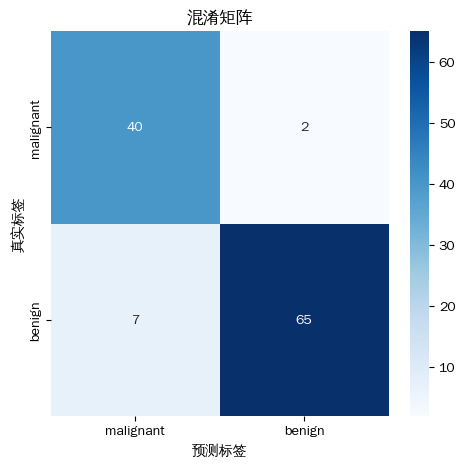

In [21]:
# 7. 混淆矩阵可视化
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=data.target_names,
            yticklabels=data.target_names)
plt.title("混淆矩阵")
plt.xlabel("预测标签")
plt.ylabel("真实标签")


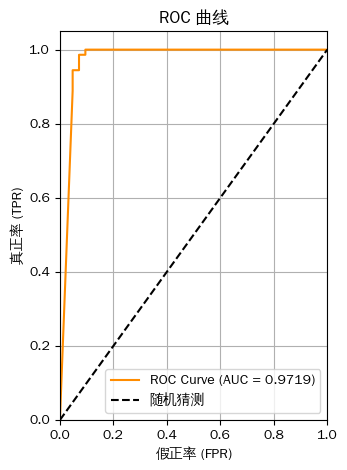

In [22]:
# 8. ROC 曲线
plt.subplot(1, 2, 2)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--', label='随机猜测')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('假正率 (FPR)')
plt.ylabel('真正率 (TPR)')
plt.title('ROC 曲线')
plt.legend(loc="lower right")
plt.grid(True)

plt.tight_layout()
plt.show()



🔍 最重要的5个特征（按系数绝对值排序）
             Feature  Coefficient
5   mean compactness   360.412168
26   worst concavity  -262.569205
16   concavity error   233.118511
13        area error  -204.435291
10      radius error  -168.371606


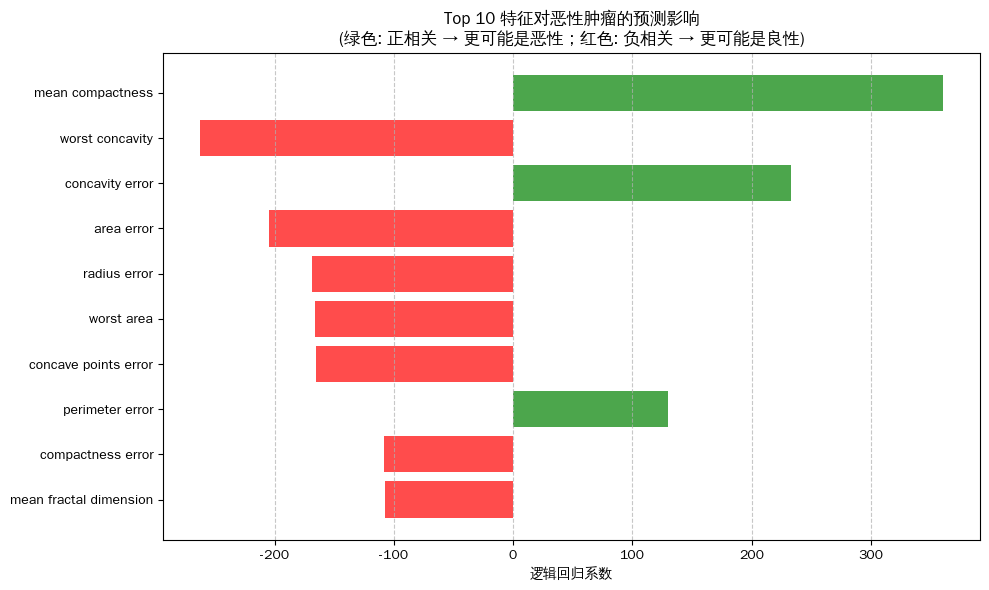

In [23]:
# 9. 【Bonus】特征重要性分析（逻辑回归系数）
coef_df = pd.DataFrame({
    'Feature': data.feature_names,
    'Coefficient': model.coef_[0]
}).sort_values(by='Coefficient', key=abs, ascending=False)

print("\n" + "="*50)
print("🔍 最重要的5个特征（按系数绝对值排序）")
print("="*50)
print(coef_df.head())

# 可视化 top 10 特征
plt.figure(figsize=(10, 6))
top_n = 10
top_features = coef_df.head(top_n)
colors = ['red' if c < 0 else 'green' for c in top_features['Coefficient']]
plt.barh(range(top_n), top_features['Coefficient'], color=colors, alpha=0.7)
plt.yticks(range(top_n), top_features['Feature'])
plt.xlabel('逻辑回归系数')
plt.title(f'Top {top_n} 特征对恶性肿瘤的预测影响\n(绿色: 正相关 → 更可能是恶性；红色: 负相关 → 更可能是良性)')
plt.gca().invert_yaxis()  # 重要性从上到下递减
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [24]:
# 10. 【进阶实验】调整决策阈值（默认是 0.5）
print("\n" + "="*50)
print("⚙️ 实验：不同决策阈值对 Precision/Recall 的影响")
print("="*50)

thresholds = [0.3, 0.5, 0.7]
for th in thresholds:
    y_pred_th = (y_pred_proba >= th).astype(int)
    prec_th = precision_score(y_test, y_pred_th)
    rec_th = recall_score(y_test, y_pred_th)
    print(f"阈值={th:>3}: 精确率={prec_th:.3f}, 召回率={rec_th:.3f}")

print("\n💡 医学场景思考：\n"
      "  - 如果漏诊恶性（假阴性）后果严重 → 应提高召回率（降低阈值）\n"
      "  - 如果误诊良性为恶性导致过度治疗 → 应提高精确率（提高阈值）")


⚙️ 实验：不同决策阈值对 Precision/Recall 的影响
阈值=0.3: 精确率=0.970, 召回率=0.903
阈值=0.5: 精确率=0.970, 召回率=0.903
阈值=0.7: 精确率=0.970, 召回率=0.903

💡 医学场景思考：
  - 如果漏诊恶性（假阴性）后果严重 → 应提高召回率（降低阈值）
  - 如果误诊良性为恶性导致过度治疗 → 应提高精确率（提高阈值）


## 图像分类预测

In [ ]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms

